# Imports and files

In [1]:
from pathlib import Path

import pandas as pd

from sainsc import read_StereoSeq

In [13]:
data_path = Path("data")
analysis_path = Path("brain")

stereo_seq_file = data_path / "StereoSeq" / "Mouse_brain_Adult_GEM_bin1.tsv.gz"

signature_file = Path(".") / "abc_brain_signatures_subclass_log.tsv"

result_path = Path("results")

In [3]:
result_path.mkdir(exist_ok=True, parents=True)

# Determine usable area

In [4]:
stereo = read_StereoSeq(stereo_seq_file, resolution=500, n_threads=16)

print(stereo)

LazyKDE (16 threads)
    genes: 26177
    shape: (10500, 13950)
    resolution: 500.0 nm / px


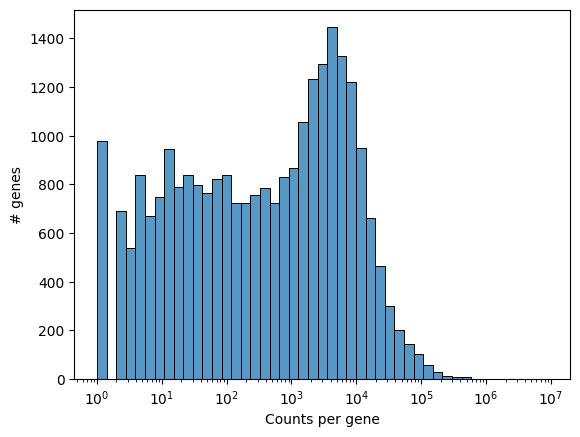

In [5]:
_ = stereo.plot_genecount_histogram()

In [6]:
stereo.gaussian_kernel(8)

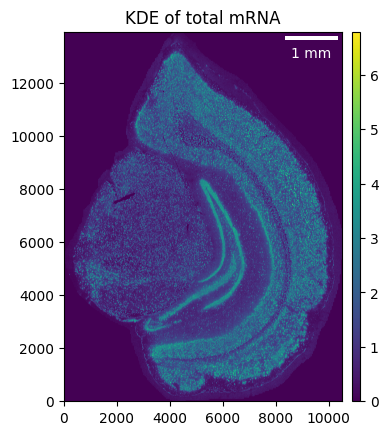

In [7]:
stereo.calculate_total_mRNA()
stereo.calculate_total_mRNA_KDE()

_ = stereo.plot_KDE()

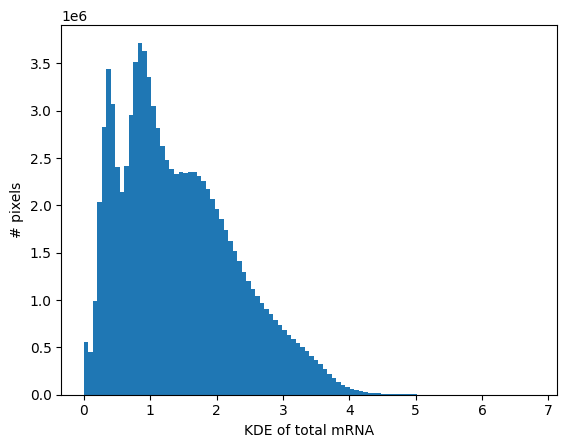

In [8]:
_ = stereo.plot_KDE_histogram(bins=100)

In [23]:
stereo.filter_background(0.7)

## Celltyping

In [10]:
signatures = pd.read_table(signature_file, index_col=0).loc[
    lambda df: df.index.isin(stereo.genes)
]

signatures.shape

(8006, 279)

In [11]:
stereo.n_threads = 24

In [12]:
stereo.assign_celltype(signatures, log=True)

print(stereo)

LazyKDE (24 threads)
    genes: 26177
    shape: (10500, 13950)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    celltypes: 279


In [5]:
import colorcet as cc
import seaborn as sns

cmap = dict(
    zip(
        stereo.celltypes,
        sns.color_palette(cc.glasbey, n_colors=len(stereo.celltypes)),
    )
)

In [28]:
import matplotlib.pyplot as plt

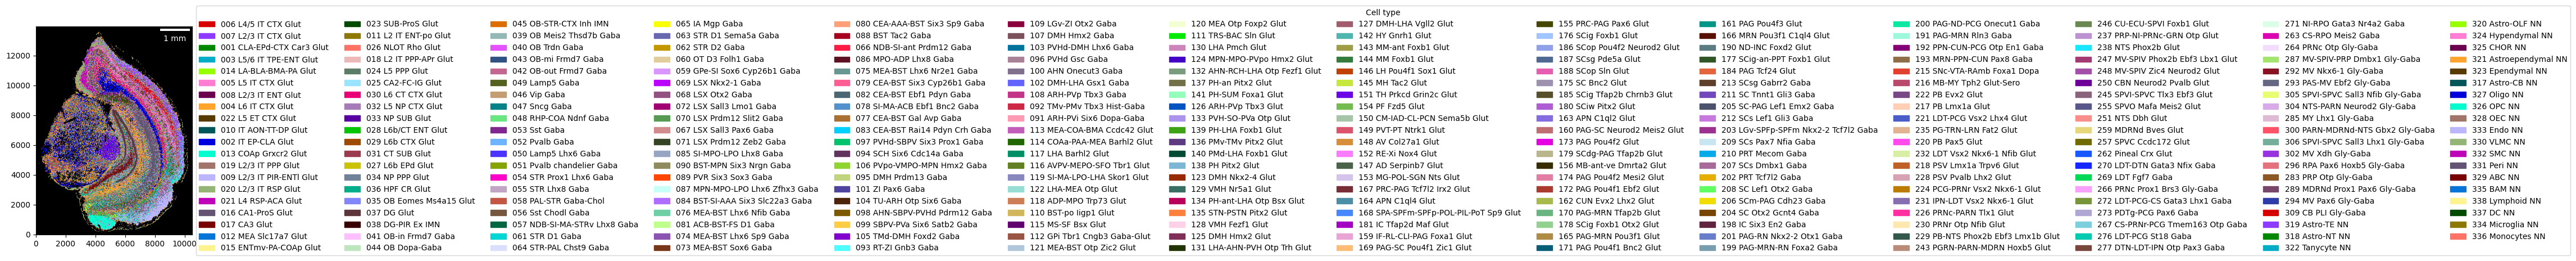

In [58]:
im = stereo.plot_celltypemap(cmap=cmap)

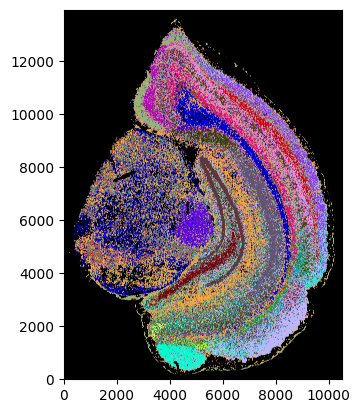

In [29]:
im = stereo.plot_celltypemap(cmap=cmap, return_img=True)
plt.imshow(im, origin="lower")

# BAM

In [5]:
from skimage import measure

In [6]:
bam_img = (
    stereo.celltype_map == stereo.celltypes.index("335 BAM NN")
) & ~stereo.background

In [7]:
bam_labels = measure.label(bam_img, background=0)

In [8]:
bam_locations = (
    pd.DataFrame(
        measure.regionprops_table(
            bam_labels, properties=["centroid", "area", "area_filled"]
        )
    )
    .rename(columns={"centroid-0": "x", "centroid-1": "y"})
    .loc[lambda df: df["area"] > 60]
)

In [14]:
bam_locations[["x", "y", "area"]].to_csv(
    result_path / "BAM_centroids.tsv", sep="\t", index=False, float_format="%.3f"
)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

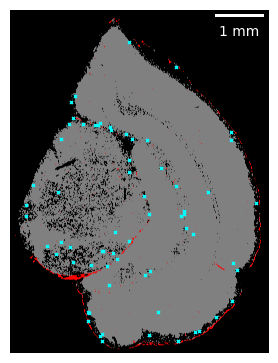

In [108]:
vascular = ["329 ABC NN", "330 VLMC NN", "331 Peri NN", "332 SMC NN", "333 Endo NN"]

im = stereo.plot_celltypemap(cmap={ct: "red" for ct in vascular}, return_img=True)

fig, ax = plt.subplots(figsize=(15 / 4.5, 5))

_ = ax.imshow(im, origin="lower")
_ = ax.scatter(bam_locations["x"], bam_locations["y"], c="cyan", s=5, marker="x", lw=1)
_ = ax.set_axis_off()
_ = ax.add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))

In [109]:
fig.savefig("figures/StereoSeq_Brain_BAM.pdf", dpi=600)